In [17]:
!jupyter nbconvert --to html LST_DEMO.ipynb  --TemplateExporter.exclude_input=False

[NbConvertApp] Converting notebook LST_DEMO.ipynb to html
[NbConvertApp] Writing 7832799 bytes to LST_DEMO.html


# LST Heatmap Extraction Tutorial

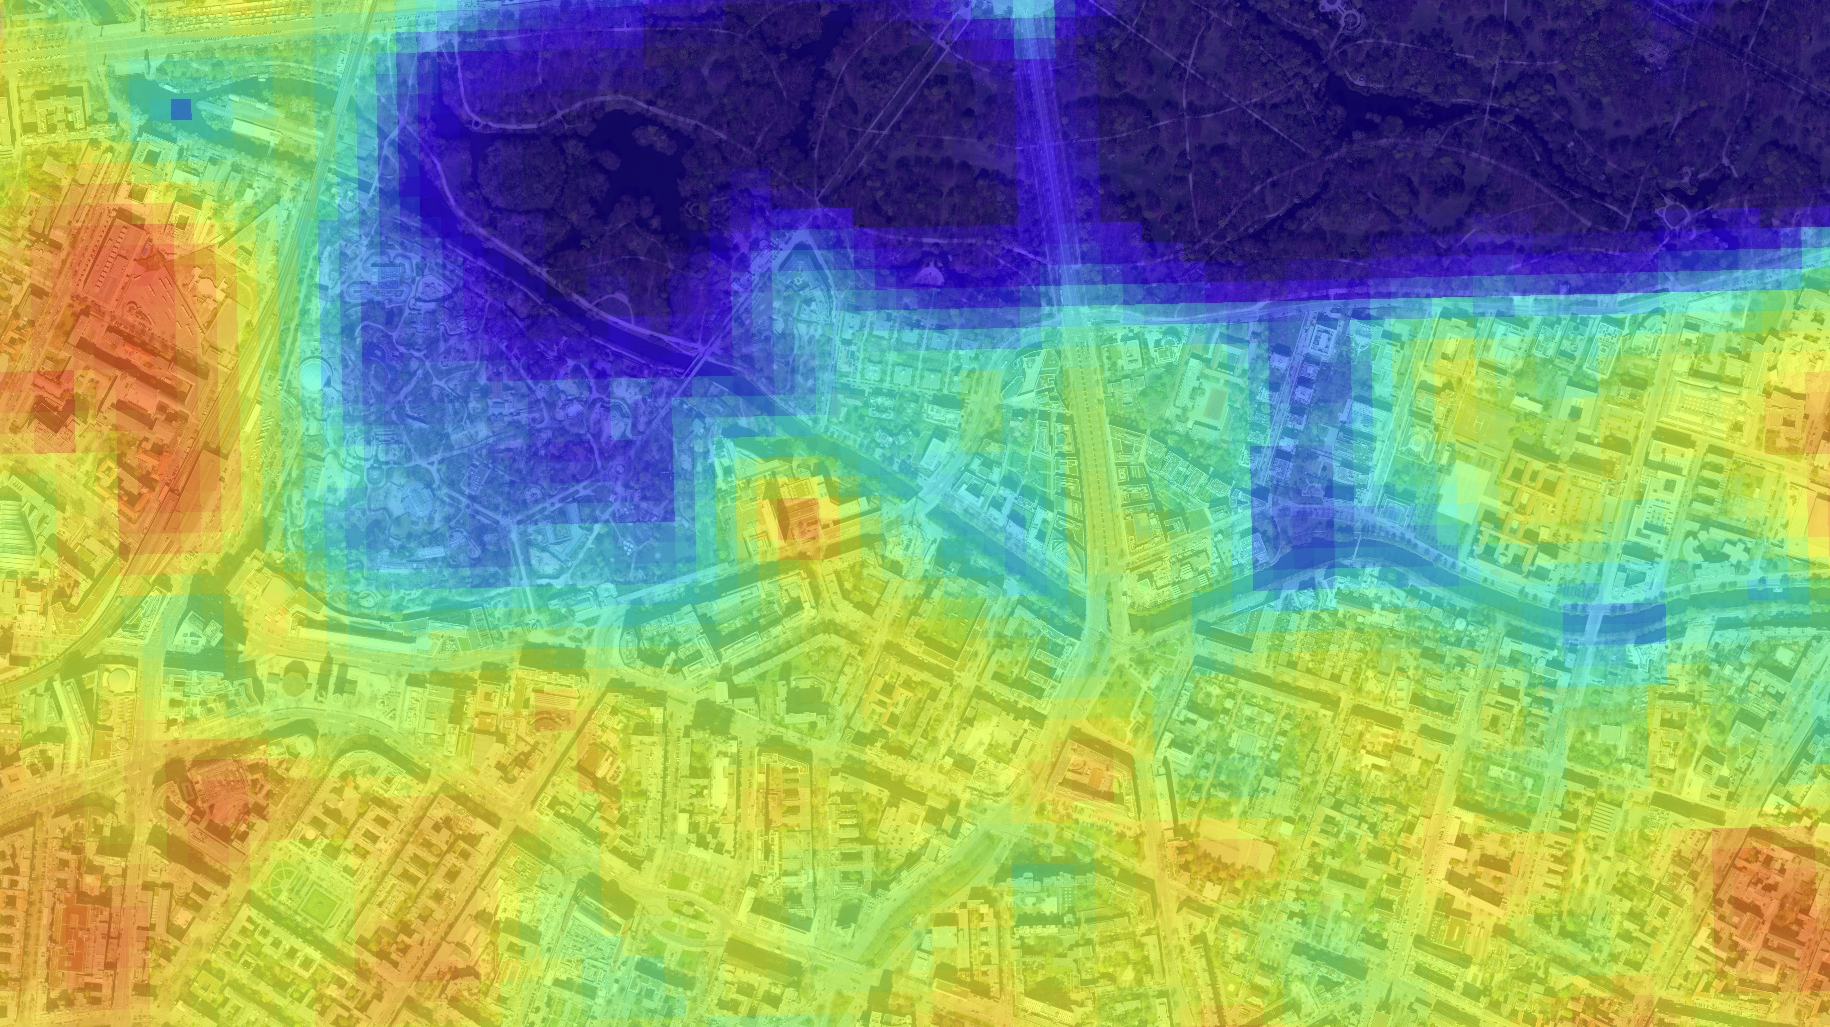


## follow these instructions for being able to run the notebook:

1. Download Anaconda for creating different python environments here: https://www.anaconda.com/anaconda-navigator
2. Create a new environment for installing geemap (library for extracting gee datasets) and its dependencies https://geemap.org/installation/#install-from-pypi

   Open Anaconda Prompt from the Search bar(should appear if Anaconda was installed correctly)
   
   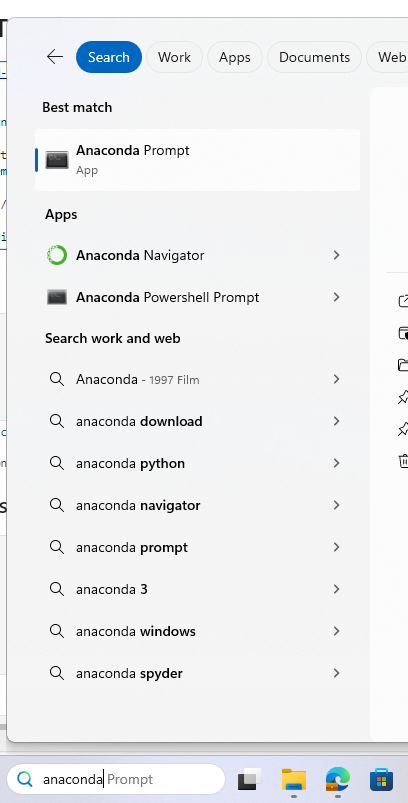
   
   Once a window opens type the following commands there:
   
   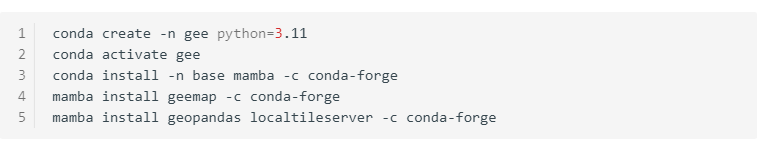
   
4. Create a google earth engine account https://earthengine.google.com/. You will need it for authenticating only the first time you run a notebook with geemap

    For that you will need a gmail account. Once you make the request it might take several days until your request gets accepted.

   These steps are also described in the video that is attached in this folder https://www.youtube.com/watch?v=h0pz3S6Tvx0
   You can find all information regarding the library here https://geemap.org/
   
6. Once you have done all this steps you should be good to go

    Open Anaconda Prompt again and type the following code:
   
   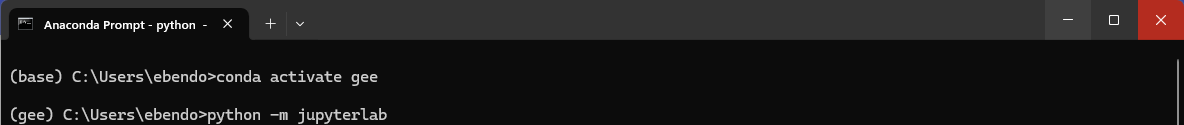
   
    Navigate to the folder where the tutorial files are saved and open the demo notebook (LST_DEMO.ipynb)
   
   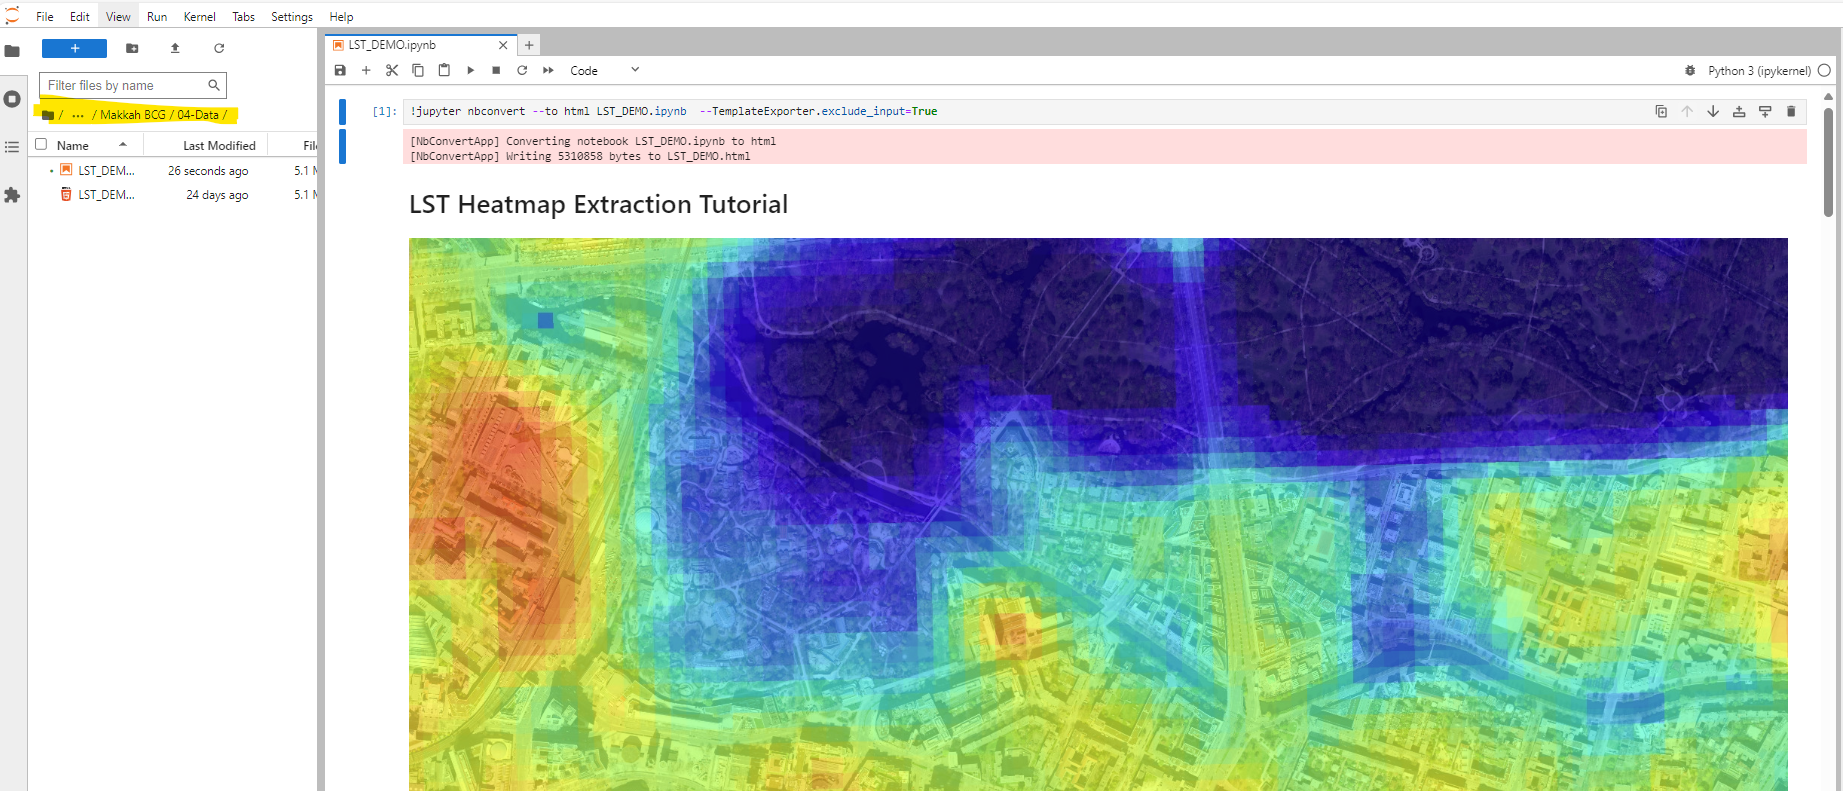

   The first time that you open the notebook you will have to authenticate the library. Watch the video from minute 6 to see how you can do that.
   
8. Now you can go through the rest of the notebook.
   Have fun extracting any dataset that is available in the Earth Engine Catalog https://developers.google.com/earth-engine/datasets/

## Import needed libraries

In [3]:
import geemap as gee
import ee
from geemap import cartoee
import numpy as np
import matplotlib.pyplot as plt
ee.Initialize()

cartopy is not installed. Please see https://scitools.org.uk/cartopy/docs/latest/installing.html#installing for instructions on how to install cartopy.

The easiest way to install cartopy is using conda: conda install -c conda-forge cartopy


## Initialize map where we will visualize the extracted geospatial layers

In [2]:
lat = 13.397462929249825
long = 52.51756525432936
zoom = 14

m = gee.Map()
m.add_basemap('SATELLITE')
m.setCenter(lat, long, zoom)
m

Map(center=[52.51756525432936, 13.397462929249825], controls=(WidgetControl(options=['position', 'transparent_…

How do add geospatial layers to it:

In [3]:
# here we are adding the CORINE landcover dataset https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_CORINE_V20_100m

dataset = ee.Image('COPERNICUS/CORINE/V20/100m/2012');
landCover = dataset.select('landcover');
m.addLayer(landCover, {}, 'Land Cover');

## How to import LST

## Dataset we are querying:
https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2

more information on the Landsat programme can be found here:

https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/media/files/LSDS-1619_Landsat8-9-Collection2-Level2-Science-Product-Guide-v5.pdf

In [9]:
# Modify start and end date or label according to your needs

start = '2021-06-01'
end =  '2021-08-30'
label = 'LST 2021'

def fmask(image):
        # see https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2
        # Bit 0 - Fill
        # Bit 1 - Dilated Cloud
        # Bit 2 - Cirrus
        # Bit 3 - Cloud
        # Bit 4 - Cloud Shadow
        qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)

        # Apply the scaling factors to the appropriate bands.
        thermalBand = image.select('ST_B.*').multiply(0.00341802).add(149.0)#.substract(273.15) for Celsius, gives error

        # Replace the original bands with the scaled ones and apply the masks.
        return image.addBands(thermalBand, None, True).updateMask(qaMask)


dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filterDate(start, end) \
            .map(fmask)

filtered_dataset = dataset.filter(ee.Filter.lt('CLOUD_COVER', 20))

meanLST = filtered_dataset.mean()

visualization = {
  'bands': [ 'ST_B10'],
  'min': 273.15 +10,
  'max': 273.15 +45,
  'palette': 'jet'
}

#print(meanLST.get('system:time_start'))
LST = m.addLayer(meanLST, visualization, label, opacity=0.7)

## What information can we retrieve from the data

### We can find out when snapshot was taken

In [3]:
# for that you need to specify the area as a bounding box, either by drawing it in the map and accessing it by uncommenting the following code

roi =m.draw_last_feature
geom = roi.geometry()
coords = geom.coordinates().getInfo()
bbox = [coords[0][0][0], coords[0][0][1], coords[0][2][0], coords[0][2][1]]
print(bbox)


[13.341773, 52.492493, 13.454182, 52.535646]


In [7]:
# you can as well give specific coordinates 
bbox = [13.341773, 52.492493, 13.454182, 52.535646]
roi = ee.Geometry.BBox(bbox[0], bbox[1], bbox[2], bbox[3])


dates=dataset.filterBounds(roi) \
    .toList(dataset.filterBounds(roi).size()) \
    .map(lambda image: ee.Date(ee.Image(image).get('system:time_start')).format(None, 'GMT')) \
    .getInfo()
newDates=[]
for date in dates:
    d=date.split("T", 1)
    newDates.append(d[1])
print(newDates)

['09:55:48', '09:56:04', '09:56:12', '09:56:17', '09:56:12', '09:56:20', '09:56:28', '09:56:36', '09:56:41', '10:01:53', '10:02:01', '10:02:12', '10:02:15', '10:02:32', '10:02:17', '10:02:25', '10:02:36', '10:02:39', '10:02:56']


## How to edit the data?

In [15]:
#It is also possible to access data over different time periods

#Usually we look into the summer periods in order to be able to detect hotspots
startDates =['2021-06-01','2022-06-01','2023-06-01' ]
endDates =['2021-08-30','2022-08-30','2023-08-30']

LST=[]

for i in range(len(startDates)):
    dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
                .filterDate(startDates[i], endDates[i]) \
                .map(fmask)

    filtered_dataset = dataset.filter(ee.Filter.lt('CLOUD_COVER', 20))

    meanLST = filtered_dataset.mean()
    LST.append(meanLST)

In [16]:
#Lets have a look into the data, satellite imagery is saved in different bands.
#In the case of Landsat data temperature is calculated in the 'ST_B10' Band
#In the next steps we will extract modify the data in this specific band

LST[0]

In [17]:
# select the needed band 
data=[]
for image in LST:
    LST = image.select("ST_B10")
    data.append(LST)
len(data)

3

In [18]:
# I can get the average of the different timeframes and visualize it in the browser view

images= ee.ImageCollection([data[0],data[1],data[2]])
average=images.reduce(ee.Reducer.mean())

visualization = {
  'bands': [ 'ST_B10_mean'],
  'min': 273.15 +10,
  'max': 273.15 +45,
  'palette': 'jet'
}
LST = m.addLayer(average, visualization, "Average Summer Temperature", opacity=0.7)

In [19]:
average

# How to download data

In [20]:
gee.ee_export_image(
    average, filename='LST.tif', scale=30, region=roi, file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to C:\Users\ebendo\OneDrive - Buro Happold\Klimaengineering\L&D\LST_Heatmaps\LST.tif


# How to visualize Heatspots and Coolspots

In [1]:
from osgeo import gdal
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap

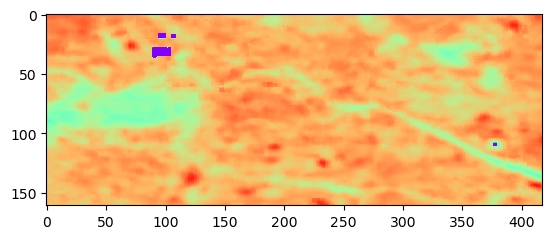

In [4]:
#based on https://www.luisalucchese.com/post/open-edit-save-raster-files-using-python/
step1 = gdal.Open('LST.tif', gdal.GA_ReadOnly)
GT_input = step1.GetGeoTransform()
step2 = step1.GetRasterBand(1)
Tarray = step2.ReadAsArray()

Tarray = Tarray-273.15 #get values in Celsius
plt.imshow(Tarray, cmap="rainbow", vmin=10, vmax=45)

In [5]:
p5 = np.percentile(Tarray, 5)
p25 = np.percentile(Tarray, 25)
p50 = np.percentile(Tarray, 50)
p75 = np.percentile(Tarray, 75)
p95 = np.percentile(Tarray, 95)

print(f'5% of data is as small or smaller than {p5}')
print(f'25% of data is as small or smaller than {p25}')
print(f'50% of data is as small or smaller than {p50}')
print(f'75% of data is as small or smaller than {p75}')
print(f'95% of data is as small or smaller than {p95}')

5% of data is as small or smaller than 30.04580703000005
25% of data is as small or smaller than 34.65329799
50% of data is as small or smaller than 36.194445229999985
75% of data is as small or smaller than 37.297896019999996
95% of data is as small or smaller than 38.82640608049999


In [ ]:
#for areas where we don't have values
Tarray[Tarray < 0] = p25

Tarray = gaussian_filter(Tarray, sigma=2)

x = np.arange(Tarray.shape[1])
y = np.arange(Tarray.shape[0])[::-1]
X, Y = np.meshgrid(x, y)
plt.figure(figsize=(Tarray.shape[1]/20,Tarray.shape[0]/20))

contour=plt.tricontourf(X.flatten(), Y.flatten(), Tarray.flatten(), levels=20, vmin=10, vmax=45,  cmap='rainbow')
plt.title('Temperature Contour Plot')
plt.colorbar(contour)  # Adds a color bar to the plot
plt.show()

In [ ]:
plt.figure(figsize=(Tarray.shape[1]/20,Tarray.shape[0]/20))

# Define a custom colormap
colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]  # Blue to white to red
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

contour=plt.tricontourf(X.flatten(), Y.flatten(), Tarray.flatten(), levels=[p5, p25, p50, p75, p95], vmin=p5, vmax=p95,  cmap=custom_cmap, extend='both')
contour.cmap.set_under('blue')
contour.cmap.set_over('red')
plt.title('Hotspots and Coolspots')
plt.colorbar(contour)  # Adds a color bar to the plot
plt.show()